2.1 Loading the MNIST dataset

In [116]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

(train_ds,test_ds),ds_info=tfds.load('mnist',split=['train','test'],as_supervised=True,with_info=True)
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [117]:
##1. How many training/test images are there?
##Ans As shown in splits above, its 60000 training images and 10000 test images

##2. What's the image shape?
##Ans The image shape is (28,28,1)

##3. What is the range of pixel values?
##Ans (0,255)

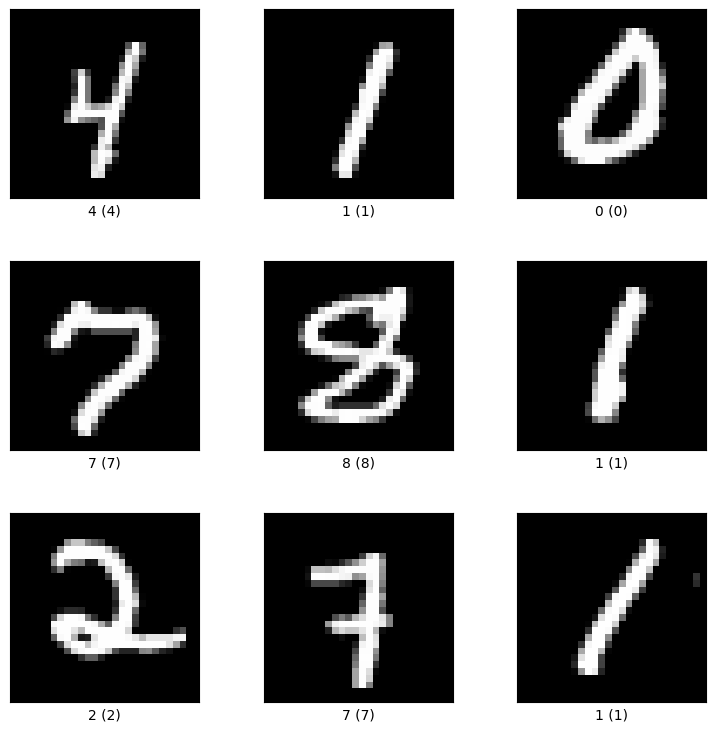

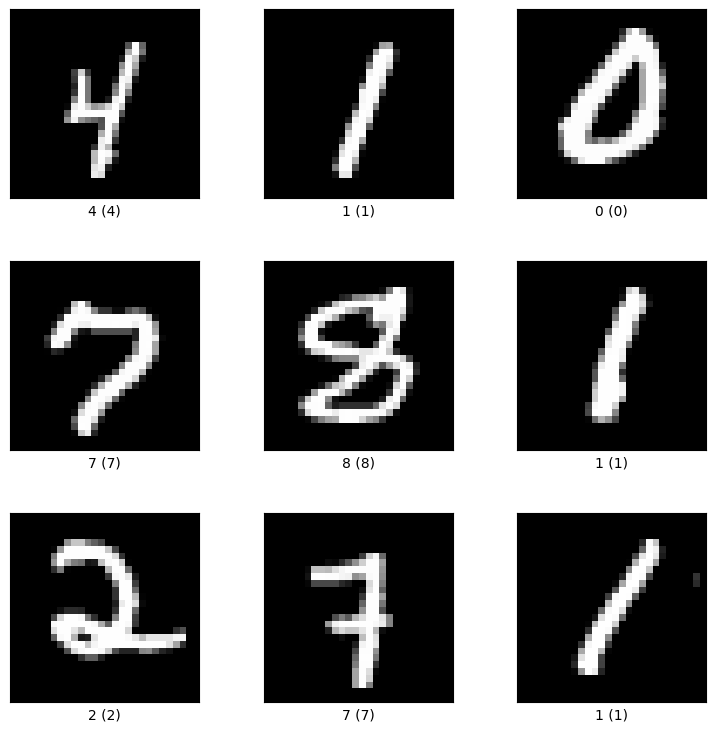

In [118]:
tfds.show_examples(train_ds ,ds_info)

2.2 Setting up the data pipeline

In [119]:
def data_prep(X):
  ## Datatype conversion from uint8 to float values
  X = X.map(lambda img, target:(tf.cast(img,tf.float32), target))
  ## Reshape the dataset to remove the 3rd dimension
  X = X.map(lambda img, target:(tf.reshape(img,(-1,)), target))
  ## Converting the values to fit the -1,1 range
  X = X.map(lambda img, target:((img/128.) -1, target))
  ## One hot encoding the targets
  X = X.map(lambda img, target:(img,tf.one_hot(target, depth=10)))
  #Using cache to avoid repetition and improve computational time
  X = X.cache()
  #Using the below to return batch wise data
  X = X.shuffle(60000)
  X = X.batch(60)
  X = X.prefetch(50)

  return X

train_ds = train_ds.apply(data_prep)
test_ds = test_ds.apply(data_prep)


2.3 Building a deep neural network with TensorFlow

In [120]:
layer_size = [256, 256, 10]

##No of layer - 1 as the last layer is taken as softmax
activation_functions_prelist = ['relu','relu']


activation_functions = []
for i in activation_functions_prelist:
  if i.lower() == 'relu':
    activation_functions.append(tf.nn.relu)
  elif i.lower() =='softmax':
    activation_functions.append(tf.nn.softmax)
  elif i.lower() == 'leakyrelu':
    activation_functions.append(tf.nn.leaky_relu)
  else:
    activation_functions.append(tf.nn.relu)


class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = Dense(layer_size[0], activation = activation_functions[0])
    self.dense2 = Dense(layer_size[1], activation = activation_functions[1])
    self.out = Dense(layer_size[2], activation = tf.nn.softmax)

  def call(self, X):
    X = self.dense1(X)
    X = self.dense2(X)
    X = self.out(X)

    return X

2.4 Creating functions for the network

In [121]:
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  train_accuracy = []
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  sample_train_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
  sample_train_accuracy = np.mean(sample_train_accuracy)
  train_accuracy.append(np.mean(sample_train_accuracy))
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.build(model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, train_accuracy

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

no_of_epochs = 5
learning_rate = 0.01
# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
loss_function = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_ds
test_dataset = test_ds

def training_loop(train_ds, test_ds, model, no_of_epochs = no_of_epochs, learning_rate = learning_rate, loss_function = loss_function, optimizer = optimizer, train_losses = train_losses ,train_accuracies = train_accuracies, test_losses = test_losses ,test_accuracies = test_accuracies):
  # We train for num_epochs epochs.
  for epoch in range(no_of_epochs):
    if epoch>=1:
      print(f'Epoch: {str(epoch)} starting with accuracy {np.round(test_accuracies[-1]*100,2)}')

    #training (and checking in with training)
    epoch_loss_agg = []
    epoch_accuracy_agg = []
    for input,target in train_dataset:
        train_loss,train_accuracy  = train_step(model, input, target, loss_function, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_accuracy_agg.append(train_accuracy)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    #track training loss
    train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, loss_function)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

2.5 Visualization

In [122]:
def visualization(train_losses = train_losses, train_accuracies = train_accuracies, test_losses = test_losses, test_accuracies = test_accuracies):
  """ Visualizes accuracy and loss for training and test data using the mean of each epoch.
  Loss is displayed in a regular line, accuracy in a dotted line.
  Training data is displayed in blue, test data in red.
  Parameters
  ----------
  train_losses : numpy.ndarray
  training losses
  train_accuracies : numpy.ndarray
  training accuracies
  test_losses : numpy.ndarray
  test losses
  test_accuracies : numpy.ndarray
  test accuracies
  """

  plt.figure()
  line1 , = plt.plot(train_losses , "b-")
  line2 , = plt.plot(test_losses , "r-")
  line3 , = plt.plot( train_accuracies , "b:")
  line4, = plt.plot( test_accuracies , "r:")
  plt.xlabel("Training steps")
  plt.ylabel("Loss / Accuracy")
  plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
  plt.show()

3 Running the model and adjusting the hyperparameters of your model

The below codes were run one after the other after the running the code blocks above this markdown cell as an optimiser error was popping up while trying to run the second iteration in the loop/code block and hence the below segregation and manual running.

The first code block has the first normal iteration run which has a final accuracy of 94.23% while having twice the no of layers compared to the other iterations.

Although the no of epochs are small to make accurate analysis in the variation of accuracy and their dependency on the parameters present, some simple and basic inferences can be made.

As seen from the below visualisations (if its not visible, then manual running of the above and one of the below cells or copying the entire above code to the code block would work although expected the backend.clear_session to work but anyways), the highest accuracy shown is by the pair having minimum learning rate and maximum momentum as represented by the relationship btw the two when it comes to gradient based optimisers.

The lowest is shown by the ones with a high learning rate and low momentum which signifies the gradient in this particular problem to have a higher momentum thus, sort of signifying the presence of noisy data and classes of data which can be classified rather easily but can be easily influenced by images shown as one type and having an other label(These inferences are with reference to examples seen as the difference isnt much but when comparing to a test size of 10000, a 1% difference would mean the correct categorisation of 100 more images).

Looking into decreasing the no of layers while increasing momentum and changing/decreasing learning rates or vice versa and playing around with other hyperparameters as well might produce interesting results based on the dataset present, type of model and data quality.

Epoch: 1 starting with accuracy 90.53
Epoch: 2 starting with accuracy 92.3
Epoch: 3 starting with accuracy 93.42
Epoch: 4 starting with accuracy 94.23


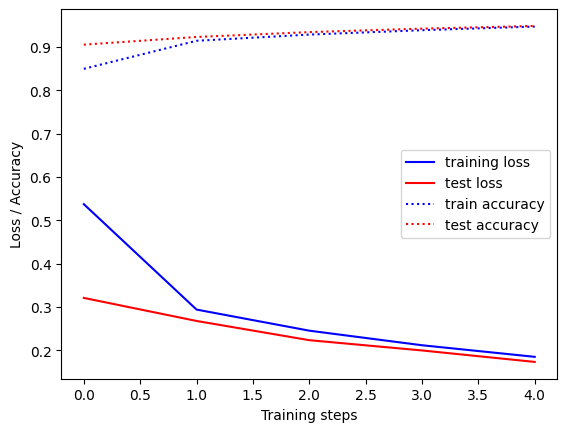

In [72]:
tf.keras.backend.clear_session()
training_loop(train_dataset, test_dataset, model)
visualization()

In [123]:
tf.keras.backend.clear_session()
layer_size = [128, 128, 10]
activation_functions_prelist = ['relu','relu']

activation_functions = []
for i in activation_functions_prelist:
  if i.lower() == 'relu':
    activation_functions.append(tf.nn.relu)
  elif i.lower() =='softmax':
    activation_functions.append(tf.nn.softmax)
  elif i.lower() == 'leakyrelu':
    activation_functions.append(tf.nn.leaky_relu)
  else:
    activation_functions.append(tf.nn.relu)

learning_rate_list = [0.01,0.1,10,0.001,100]
no_of_epochs = 5
loss_function_list = [tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.CategoricalFocalCrossentropy(), tf.keras.losses.CategoricalFocalCrossentropy(), tf.keras.losses.CategoricalCrossentropy(), tf.keras.losses.CategoricalCrossentropy()]
optimizer_momentum_list = [1,0.8,0.6,1,1]



Epoch: 1 starting with accuracy 90.36
Epoch: 2 starting with accuracy 92.26
Epoch: 3 starting with accuracy 93.26
Epoch: 4 starting with accuracy 93.77


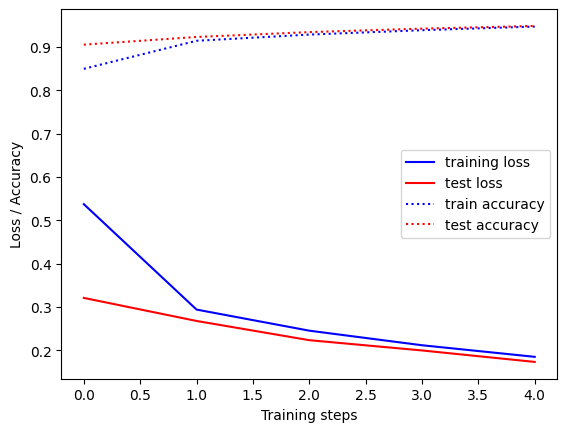

In [82]:
tf.keras.backend.clear_session()
model = MyModel()
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

learning_rate = learning_rate_list[0]
loss_function = loss_function_list[0]
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum = optimizer_momentum_list[0])
training_loop(train_dataset, test_dataset, model, no_of_epochs = no_of_epochs)
visualization()

Epoch: 1 starting with accuracy 90.78
Epoch: 2 starting with accuracy 92.34
Epoch: 3 starting with accuracy 93.32
Epoch: 4 starting with accuracy 93.85


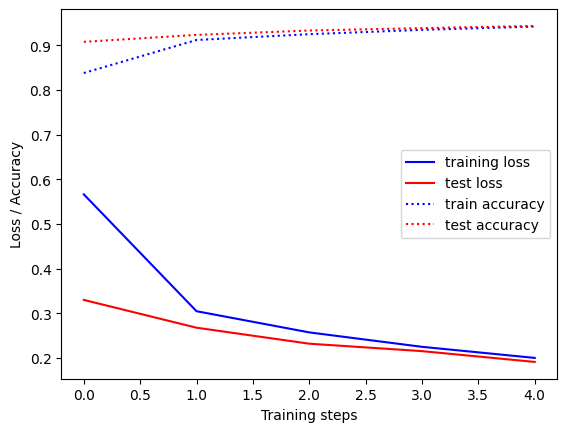

In [124]:
tf.keras.backend.clear_session()
model = MyModel()
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

learning_rate = learning_rate_list[1]
loss_function = loss_function_list[1]
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum = optimizer_momentum_list[1])
training_loop(train_dataset, test_dataset, model, no_of_epochs = no_of_epochs)
visualization()

Epoch: 1 starting with accuracy 90.39
Epoch: 2 starting with accuracy 91.74
Epoch: 3 starting with accuracy 93.13
Epoch: 4 starting with accuracy 93.68


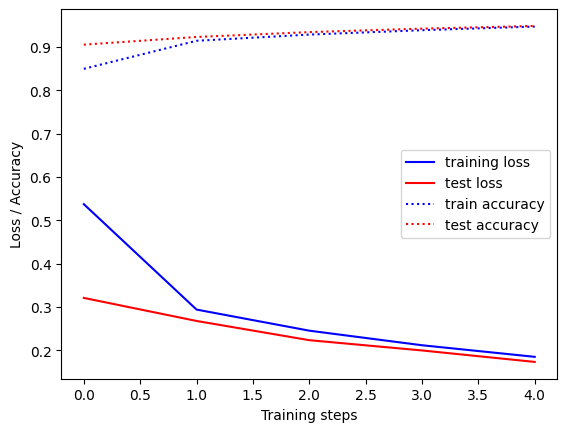

In [98]:
tf.keras.backend.clear_session()
model = MyModel()
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

learning_rate = learning_rate_list[2]
loss_function = loss_function_list[2]
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum = optimizer_momentum_list[2])
training_loop(train_dataset, test_dataset, model, no_of_epochs = no_of_epochs)
visualization()

Epoch: 1 starting with accuracy 90.18
Epoch: 2 starting with accuracy 91.7
Epoch: 3 starting with accuracy 93.1
Epoch: 4 starting with accuracy 94.09


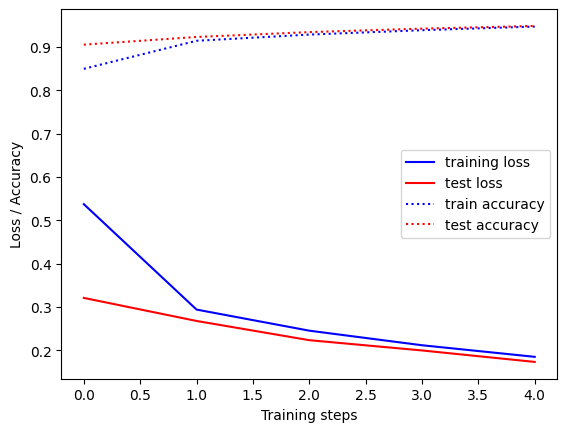

In [106]:
tf.keras.backend.clear_session()
model = MyModel()
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

learning_rate = learning_rate_list[3]
loss_function = loss_function_list[3]
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum = optimizer_momentum_list[3])
training_loop(train_dataset, test_dataset, model, no_of_epochs = no_of_epochs)
visualization()

Epoch: 1 starting with accuracy 90.78
Epoch: 2 starting with accuracy 92.58
Epoch: 3 starting with accuracy 93.05
Epoch: 4 starting with accuracy 93.89


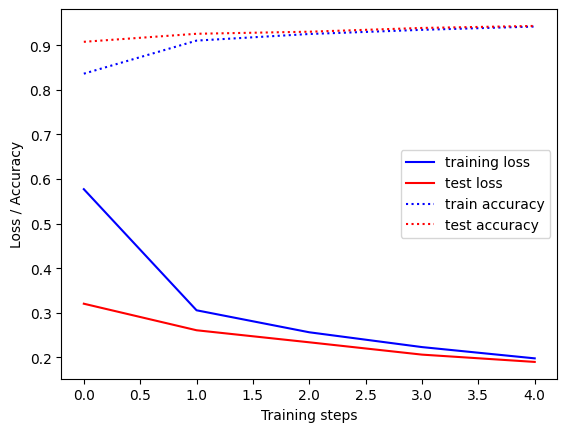

In [115]:
tf.keras.backend.clear_session()
model = MyModel()
train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

learning_rate = learning_rate_list[4]
loss_function = loss_function_list[4]
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum = optimizer_momentum_list[4])
training_loop(train_dataset, test_dataset, model, no_of_epochs = no_of_epochs)
visualization()